In [22]:
import keras
from keras.layers import Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.datasets import mnist


import pandas as pd
import numpy as np

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [23]:
(keras_train_images, keras_train_labels), (keras_test_images, keras_test_labels)   = mnist.load_data()


In [26]:
keras_train_images = keras_train_images/255.0
keras_train_images = keras_train_images.reshape(keras_train_images.shape[0], 28, 28, 1)

keras_test_images = keras_test_images/255.0
keras_test_images = keras_test_images.reshape(keras_test_images.shape[0], 28, 28, 1)



In [29]:
keras_train_labels = to_categorical(keras_train_labels)
keras_test_labels = to_categorical(keras_test_labels)


In [5]:
test = data_test.values


label = to_categorical(data.label)
data = data.values
train = data[:, 1:]

(<matplotlib.image.AxesImage at 0x250f71f61d0>,
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))

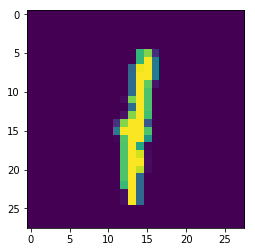

In [6]:
plt.imshow(train[12].reshape(28,28)), label[12]

In [7]:
train = train.reshape(train.shape[0], 28, 28, 1)
test = test.reshape(test.shape[0], 28, 28, 1)

In [8]:
train.shape, test.shape

((42000, 28, 28, 1), (28000, 28, 28, 1))

In [9]:
train = train/255.0
test = test/255.0

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train, label, test_size=0.1)

In [32]:
x_train = np.concatenate((x_train, keras_train_images), axis=0)
y_train = np.concatenate((y_train, keras_train_labels),axis=0)

In [35]:
x_test = np.concatenate((x_test, keras_test_images), axis=0)
y_test = np.concatenate((y_test, keras_test_labels),axis=0)

In [44]:
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=0.3,
        fill_mode='nearest')
datagen.fit(x_train)

In [45]:
# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size=(3, 3),  padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3),  padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dense(10, activation='softmax'))
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
adam = Adam(lr=0.0001, decay=1e-6)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])



In [46]:
#train_datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, horizontal_flip=True, rotation_range=0.2)
#train_datagen.fit(x_train)

In [47]:
model.fit_generator(datagen.flow(x_train, y_train), x_train.shape[0] // 256, epochs=100, workers=4,
                   validation_data=(x_test, y_test), callbacks=[EarlyStopping(min_delta=0.001, patience=10)])

Epoch 1/100
382/382 [==============================] - 12s 31ms/step - loss: 0.2589 - acc: 0.9169 - val_loss: 0.0808 - val_acc: 0.9755
Epoch 2/100
382/382 [==============================] - 10s 26ms/step - loss: 0.1170 - acc: 0.9638 - val_loss: 0.0656 - val_acc: 0.9809
Epoch 3/100
382/382 [==============================] - 10s 26ms/step - loss: 0.0811 - acc: 0.9750 - val_loss: 0.0635 - val_acc: 0.9808
Epoch 4/100
382/382 [==============================] - 10s 26ms/step - loss: 0.0797 - acc: 0.9762 - val_loss: 0.0551 - val_acc: 0.9830
Epoch 5/100
382/382 [==============================] - 10s 26ms/step - loss: 0.0717 - acc: 0.9780 - val_loss: 0.0655 - val_acc: 0.9790
Epoch 6/100
382/382 [==============================] - 10s 27ms/step - loss: 0.0686 - acc: 0.9788 - val_loss: 0.0397 - val_acc: 0.9870
Epoch 7/100
382/382 [==============================] - 10s 26ms/step - loss: 0.0560 - acc: 0.9833 - val_loss: 0.0367 - val_acc: 0.9883
Epoch 8/100
382/382 [==============================] - 

In [48]:
preds = model.predict(test)

In [49]:
def save_preds(preds, fname):
    pred = np.argmax(preds, axis=1)
    with open(fname, "w") as fp:
        fp.write("ImageId,Label\n")
        for i, p in enumerate(pred):
            fp.write("{},{}\n".format(i+1, p))
        
    

In [50]:
save_preds(preds, 'sub_1.csv')

In [ ]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=20,
                        validation_data=(x_test, y_test))